In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# Load Data

In [2]:
original_train_image = np.load(r'C:\Users\user\Desktop\ECG_Project\train_image_new.npy')
original_test_image = np.load(r'C:\Users\user\Desktop\ECG_Project\test_image.npy')
original_train_Y = np.load(r'C:\Users\user\Desktop\ECG_Project\train_label.npy')
original_test_Y = np.load(r'C:\Users\user\Desktop\ECG_Project\test_label.npy')

In [3]:
print(original_train_image.shape, original_train_Y.shape)
print(original_test_image.shape, original_test_Y.shape)

(87554, 187, 187) (87554,)
(21892, 187, 187) (21892,)


### Check Data

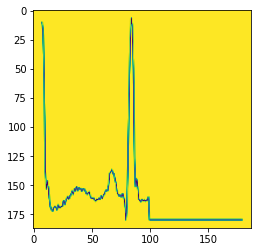

In [4]:
plt.imshow(original_train_image[0])

In [5]:
train_Y_full = original_train_Y.astype('int8')
test_Y = original_test_Y.astype('int8')

In [6]:
import collections

train_count = dict(collections.Counter(train_Y_full))
print(train_count)
print(train_Y_full.shape[0])
test_count = dict(collections.Counter(test_Y))

{0: 72471, 1: 2223, 2: 5788, 3: 641, 4: 6431}
87554


# EDA
- 매우 불균형한 데이터. 정상이 거의 대부분을 차지

- 비정상 간에도 불균형 존재. ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- 2번과 4번이 3배 이상으로 훨씬 많음
- Train Test는 stratify가 잘 들어가있음

(-1.1093222463972647,
 1.1266067768709302,
 -1.1212783829807198,
 1.1010132563324153)

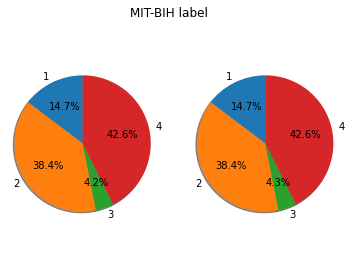

In [7]:
x1 = list(train_count.keys())
x2 = list(test_count.keys())
y1 = list(train_count.values())
y2 = list(test_count.values())
x1.pop(0);x2.pop(0);y1.pop(0);y2.pop(0)


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (10, 5)
fig.suptitle('MIT-BIH label')
ax1.pie(y1, labels = x1, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

ax2.pie(y2, labels = x2, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')

(-1.1048542973054118,
 1.1048386516489892,
 -1.1061704118723004,
 1.1002938454226878)

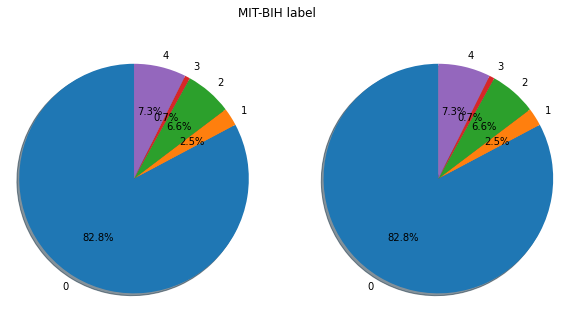

In [8]:
x1 = list(train_count.keys())
x2 = list(test_count.keys())
y1 = list(train_count.values())
y2 = list(test_count.values())

fig, (ax1, ax2) = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
fig.suptitle('MIT-BIH label')
ax1.pie(y1, labels = x1, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

ax2.pie(y2, labels = x2, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')

# Preprocessing
1. add channel
1. validation split
1. zero center
1. to categorical

### Add Channel

In [9]:
# Channel
print(original_train_image.shape, original_test_image.shape)
train_X_full = original_train_image.reshape(-1, 187, 187, 1) 
del original_train_image # free resource
test_X = original_test_image.reshape(-1, 187, 187, 1)
del original_test_image
print(train_X_full.shape, test_X.shape)

(87554, 187, 187) (21892, 187, 187)
(87554, 187, 187, 1) (21892, 187, 187, 1)


### Data Split
#### use 8991 validation data, consists of
0 : 82.8% - 7452 개  
1 : 2.5% - 225 개  
2 : 6.6% - 594 개  
3 : 0.7% - 63 개  
4 : 7.3% - 657 개  

In [10]:
# Data Split
df = pd.DataFrame(train_Y_full, columns = ['label'])
print(df.value_counts())

# 데이터 레이블에 해당하는 인덱스값들 추출
label0 = df.index[df['label'] ==0].tolist()
label1 = df.index[df['label'] ==1].tolist()
label2 = df.index[df['label'] ==2].tolist()
label3 = df.index[df['label'] ==3].tolist()
label4 = df.index[df['label'] ==4].tolist()

# 랜덤으로 데이터 레이블에서 인덱스값을 뽑음
import random
random.seed(0)
val_0 = random.sample(label0, 7452)
val_1 = random.sample(label1, 225)
val_2 = random.sample(label2, 594)
val_3 = random.sample(label3, 63)
val_4 = random.sample(label4, 657)
del df
val_index = val_0 + val_1 + val_2 + val_3 + val_4
print(len(val_index))

train_X = np.delete(train_X_full, val_index, axis = 0)
val_X = train_X_full[val_index]
del train_X_full

train_Y = np.delete(train_Y_full, val_index, axis = 0)
val_Y = train_Y_full[val_index]
del train_Y_full

print(val_X.shape, val_Y.shape,train_X.shape, train_Y.shape)

label
0        72471
4         6431
2         5788
1         2223
3          641
dtype: int64
8991
(8991, 187, 187, 1) (8991,) (78563, 187, 187, 1) (78563,)


In [12]:
print("val :", val_X.shape, val_Y.shape,"train :", train_X.shape, train_Y.shape)
print(train_X.shape, train_Y.shape)

val : (8991, 187, 187, 1) (8991,) train : (78563, 187, 187, 1) (78563,)
(78563, 187, 187, 1) (78563,)


### Zero Center

In [13]:
# zero center
zero_centerer = np.mean(train_X, axis = 0)
train_X -= zero_centerer
val_X -= zero_centerer
test_X -= zero_centerer

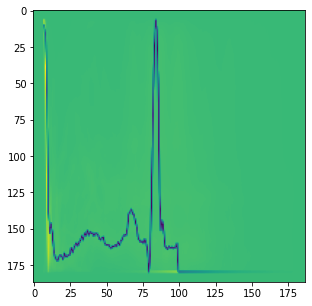

In [14]:
plt.imshow(train_X[0])

### One Hot

In [16]:
from keras.utils.np_utils import to_categorical

train_Y = to_categorical(train_Y, num_classes = 5)
val_Y = to_categorical(val_Y, num_classes = 5)
test_Y = to_categorical(test_Y, num_classes = 5)

### Save Data

In [17]:
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\train_image.npy", train_X)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\validation_image.npy", val_X)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\test_image.npy", test_X)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\train_label.npy",train_Y)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\validation_label.npy", val_Y)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\test_label.npy", test_Y)
np.save(r"C:\Users\user\Desktop\ECG_Project\MIT-BIH\mitbih_image\zero_centerer.npy", zero_centerer)